# LR estimation

We estimate a suitable learning rate by training each model with a learning rate that exponentially increases in every epoch.
We start with a learning rate of 1e-7 and increase it by multiplying it with factor 1.4.
By plotting the training loss against the learning rate, we identify the most suitable learning rate as the point where the curve shows the steepest descent, meaning the model learns best.

Note that for all sequential models we use teacher forcing without scheduled sampling for a fair comparison between learning rates.

In [1]:
import numpy as np
import os.path as osp
import os
from matplotlib import pyplot as plt
import glob

In [2]:
base_dir = '/home/fiona/birdMigration/results/abm'
fig_dir = '/home/fiona/birdMigration/data/plots/LR_estimation_abm'
dpi = 600

os.makedirs(fig_dir, exist_ok=True)

In [41]:
def load_lr_estimation(year, model, ext='', pre=''):

    model_dir = osp.join(base_dir, f'{pre}{model}', f'test_{year}', 
                          f'LR_estimation{ext}')
    lr_files = glob.glob(model_dir + f"/**/learning_rates.npy", recursive = True)
    lr, loss = [], []
    for f in lr_files:
        lr.append(np.load(f))
        loss.append(np.load(osp.join(osp.dirname(f), 'training_curves.npy'))[0])
        #loss.append(np.load(osp.join(osp.dirname(f), 'validation_curves.npy'))[0])
    lr = np.stack(lr)
    loss = np.stack(loss)
    
    return lr, loss

def plot(year, models, ext='', start=0, stop=-10, mark_lr='best', log=True):
    fig, ax = plt.subplots(figsize=(8, 4))
    for i, m in enumerate(models):
        lr, loss = load_lr_estimation(year, m, ext)
        print(f'{m}: best lr = {lr[0, np.argmin(np.gradient(loss.mean(0))[start:stop])]}')
        line = ax.errorbar(lr.mean(0)[start:stop], loss.mean(0)[start:stop], yerr=loss.std(0)[start:stop], label=m)
        #line = ax[1].plot(lr.mean(0)[start:stop], np.gradient(loss.mean(0))[start:stop], label=str(y))
        
        if mark_lr == 'best':
            best_lr = lr[0, np.argmin(np.gradient(loss.mean(0))[start:stop])]
            ax.axvline(best_lr, color=line[0].get_color(), ls=':')
        elif isinstance(mark_lr, float):
            ax.axvline(mark_lr, color=line[0].get_color(), ls=':')
    ax.set(xscale='log', xlabel='learning rate', ylabel='loss')
    if log:
        ax.set(yscale='log')
    ax.legend()
    fig.tight_layout()
    return fig

## Model: FluxGraphLSTM
### With 0 graph layers

year 2017: best lr = 2.295856928869812e-06


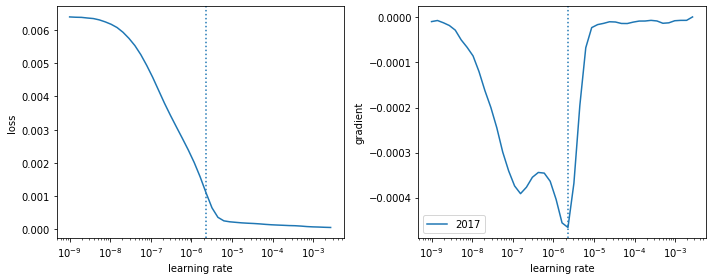

In [24]:
fig = plot([2017], 'FluxGraphLSTM', ext = '', stop=-15, log=False)
fig.savefig(osp.join(fig_dir, 'FluxGraphLSTM.png'), bbox_inchesa='tight', dpi=dpi)

year 2017: best lr = 4.268788542106363e-07


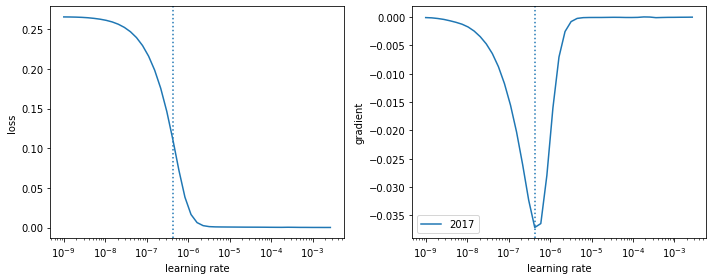

In [24]:
fig = plot([2017], 'FluxGraphLSTM', ext = '', start=0, stop=-15, log=False)
fig.savefig(osp.join(fig_dir, 'FluxGraphLSTM.png'), bbox_inches='tight', dpi=dpi)

## Model: LocalLSTM

year 2017: best lr = 7.937147732541433e-08


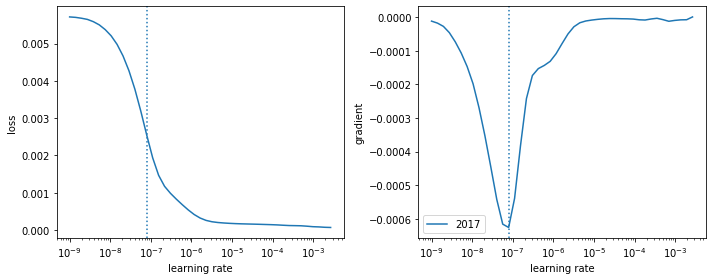

In [20]:
fig = plot([2017], 'LocalLSTM', stop=-15, log=False)
fig.savefig(osp.join(fig_dir, 'LocalLSTM.png'), bbox_inches='tight', dpi=dpi)

0.020248916239764315
LocalLSTM: best lr = 5.976303958948908e-07
0.020248916239764315
FluxGraphLSTM: best lr = 4.268788542106363e-07


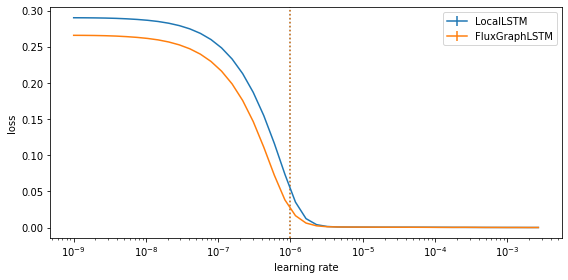

In [39]:
fig = plot(2017, ['LocalLSTM', 'FluxGraphLSTM'], stop=-15, mark_lr=1e-6, log=False)
fig.savefig(osp.join(fig_dir, 'LR_estimation_both.png'), bbox_inches='tight', dpi=dpi)

LocalLSTM: best lr = 7.937147732541433e-08


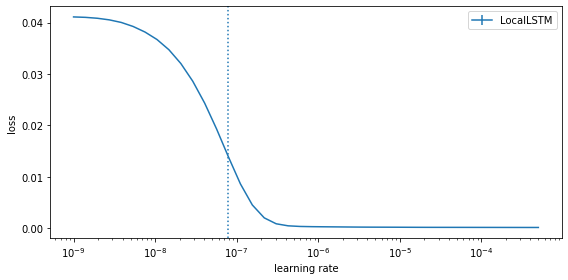

In [42]:
fig = plot(2017, ['LocalLSTM'], ext='_128', log=False)

LocalLSTM: best lr = 1.1112006825558006e-07


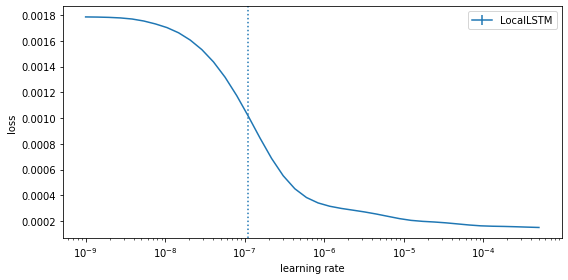

In [46]:
fig = plot(2017, ['LocalLSTM'], ext='_64', log=False)

FluxGraphLSTM: best lr = 3.0491346729331165e-07


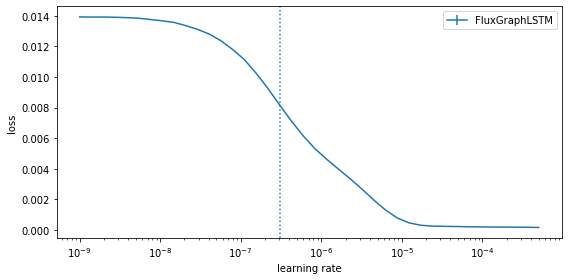

In [45]:
fig = plot(2017, ['FluxGraphLSTM'], ext='_64', log=False)

FluxGraphLSTM: best lr = 7.937147732541433e-08


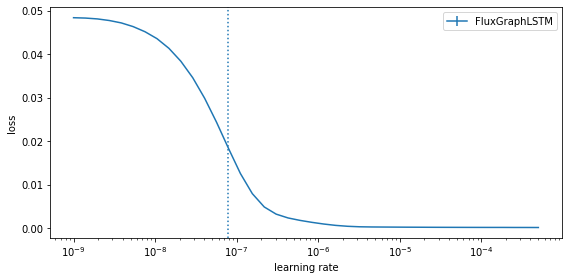

In [47]:
fig = plot(2017, ['FluxGraphLSTM'], ext='_128', log=False)

FluxGraphLSTM: best lr = 5.976303958948908e-07


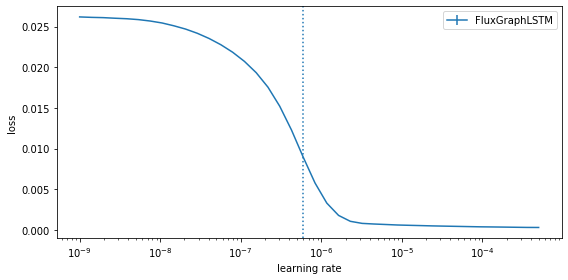

In [52]:
fig = plot(2017, ['FluxGraphLSTM'], ext='_128_importance_sampling', log=False)

FluxGraphLSTM: best lr = 2.295856928869812e-06


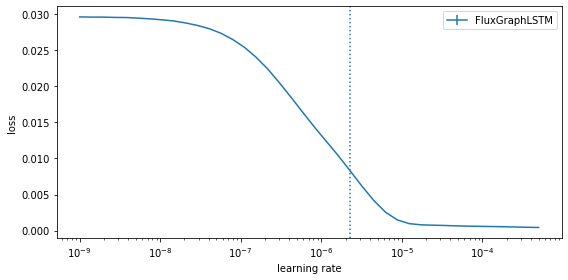

In [53]:
fig = plot(2017, ['FluxGraphLSTM'], ext='_64_importance_sampling', log=False)